# Student Loan Risk with Deep Learning

In [1]:
# Imports
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, Adamax, Nadam

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE

from pathlib import Path

import numpy as np
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor


---

## Part 1: Prepare the data to be used on a neural network model

### Step 1: Read the `student-loans.csv` file into a Pandas DataFrame. Review the DataFrame, looking for columns that could eventually define your features and target variables.   

In [2]:
# Read the csv into a Pandas DataFrame
file_path = "https://static.bc-edx.com/ai/ail-v-1-0/m18/lms/datasets/student-loans.csv"
loans_df = pd.read_csv(file_path)

# Review the DataFrame
display (loans_df.head())
display (loans_df.shape)

,payment_history,location_parameter,stem_degree_score,gpa_ranking,alumni_success,study_major_code,time_to_completion,finance_workshop_score,cohort_ranking,total_loan_score,financial_aid_score,credit_ranking
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,1
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0


(1599, 12)

In [3]:
# Review the data types associated with the columns
loans_df.dtypes

payment_history           float64
location_parameter        float64
stem_degree_score         float64
gpa_ranking               float64
alumni_success            float64
study_major_code          float64
time_to_completion        float64
finance_workshop_score    float64
cohort_ranking            float64
total_loan_score          float64
financial_aid_score       float64
credit_ranking              int64
dtype: object

In [4]:
# Check the credit_ranking value counts
display (loans_df["credit_ranking"].value_counts())
# another way of looking at the feature. not prefered as this does not show the count per class
display (loans_df['credit_ranking'].unique())

credit_ranking
1    855
0    744
Name: count, dtype: int64

array([0, 1], dtype=int64)

### Step 2: Using the preprocessed data, create the features (`X`) and target (`y`) datasets. The target dataset should be defined by the preprocessed DataFrame column “credit_ranking”. The remaining columns should define the features dataset.

In [5]:
# Define the target set y using the credit_ranking column

y = loans_df['credit_ranking']
# Display a sample of y

np.array(y)[:5]

array([0, 0, 0, 1, 0], dtype=int64)

In [6]:
# Define features set X by selecting all columns but credit_ranking
X=loans_df.drop(columns=['credit_ranking'])

# Review the features DataFrame
display (X.head())


,payment_history,location_parameter,stem_degree_score,gpa_ranking,alumni_success,study_major_code,time_to_completion,finance_workshop_score,cohort_ranking,total_loan_score,financial_aid_score
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4


### Step 3: Split the features and target sets into training and testing datasets.


In [7]:
# Calculating VIF for each feature
vif = pd.DataFrame()
vif["feature"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Displaying VIF scores
sorted_vif =  vif.sort_values(by='VIF', ascending=False)
print(sorted_vif)

                   feature          VIF
7   finance_workshop_score  1479.287209
8           cohort_ranking  1070.967685
10     financial_aid_score   124.394866
0          payment_history    74.452265
9         total_loan_score    21.590621
1       location_parameter    17.060026
2        stem_degree_score     9.183495
4           alumni_success     6.554877
6       time_to_completion     6.519699
5         study_major_code     6.442682
3              gpa_ranking     4.662992


In [8]:
# trying different feature sets to improve loss and accuracy
# drop_columns = ['finance_workshop_score','cohort_ranking','financial_aid_score','payment_history','total_loan_score','location_parameter']
drop_columns = ['gpa_ranking','alumni_success','finance_workshop_score','cohort_ranking']
# X = X.drop(columns=drop_columns)

In [9]:
# Calculating VIF for each feature
vif = pd.DataFrame()
vif["feature"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Displaying VIF scores
sorted_vif = vif.sort_values(by='VIF', ascending=False)
print(sorted_vif)

                   feature          VIF
7   finance_workshop_score  1479.287209
8           cohort_ranking  1070.967685
10     financial_aid_score   124.394866
0          payment_history    74.452265
9         total_loan_score    21.590621
1       location_parameter    17.060026
2        stem_degree_score     9.183495
4           alumni_success     6.554877
6       time_to_completion     6.519699
5         study_major_code     6.442682
3              gpa_ranking     4.662992


# Split the preprocessed data into a training and testing dataset
# Assign the function a random_state equal to 1
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.2,random_state=1)

In [10]:
# Assume X and y are your features and labels respectively
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.40, random_state=1)  # Split into training and temp (validation + test)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=1)  # Split the temp into validation and test


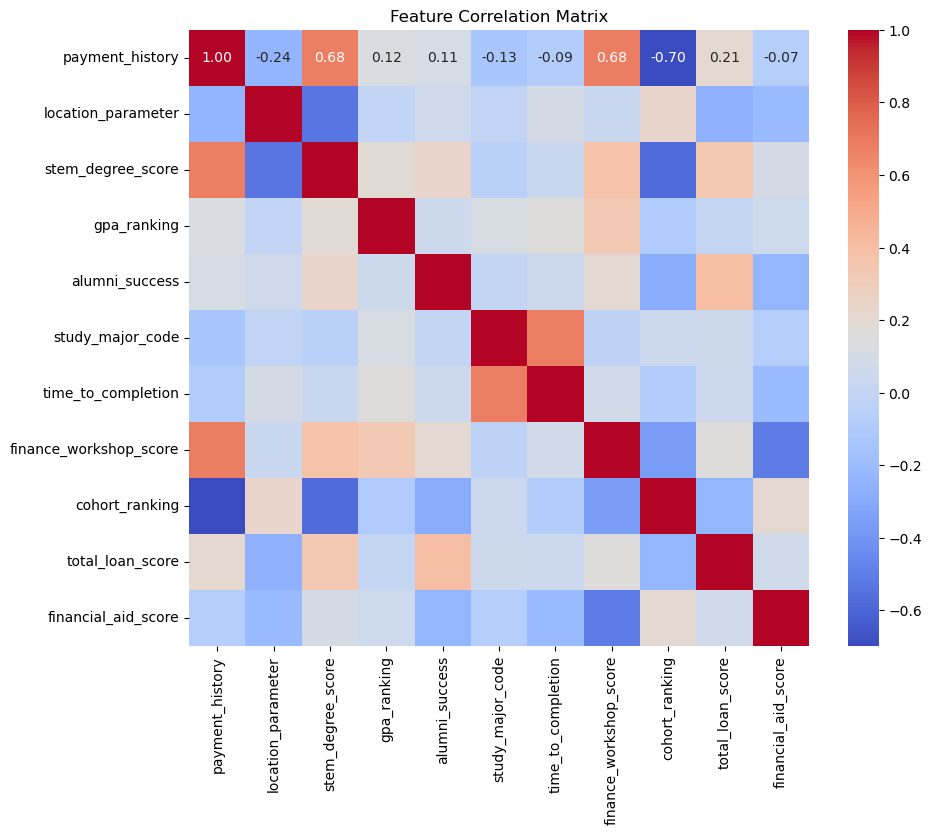

In [11]:
# Check for high corrilation
correlation_matrix = X_train.corr()

# Plotting the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()

### Step 4: Use scikit-learn's `StandardScaler` to scale the features data.

In [12]:
# Step 1: Create a StandardScaler instance
scaler = StandardScaler()

# Step 2: Fit the scaler to the features training dataset
scaler.fit(X_train)

# Step 3: Transform the features training dataset
X_train_scaled = scaler.transform(X_train)

# Step 4: Transform the features testing dataset
X_test_scaled = scaler.transform(X_test)

# Step 4: Transform the features testing dataset
X_val_scaled = scaler.transform(X_val)


# Optional: Display the first few entries of the scaled features to verify the scaling
# print("Scaled X_train sample:\n", X_train_scaled[:5])
# print("Scaled X_test sample:\n", X_test_scaled[:5])

---

## Part 2 Compile and Evaluate a Model Using a Neural Network

### Step 1: Create a deep neural network by assigning the number of input features, the number of layers, and the number of neurons on each layer using Tensorflow’s Keras.

> **Hint** You can start with a two-layer deep neural network model that uses the `relu` activation function for both layers.


In [13]:
# Define the the number of inputs (features) to the model
input_nodes  = X_train_scaled.shape[1]
# or 
# input_nodes = len(X.columns)

# Review the number of features
display ("Number of input features:", input_nodes )

'Number of input features:'

11

# Neural Network Configuration Guide

## 1. Define the Number of Hidden Nodes for the First Hidden Layer
For the first hidden layer, a common approach is to start with a number of nodes that is somewhere between the number of input features and the number of output neurons. A typical strategy might be to use a number of nodes that is the mean or the geometric mean of these two numbers, adjusted based on the complexity of the problem or empirical testing.

## 2. Define the Number of Hidden Nodes for the Second Hidden Layer
For the second hidden layer, you might choose to reduce the number of nodes compared to the first hidden layer. This is often done to gradually reduce the dimensionality and to aggregate the features extracted by the first layer. A typical rule might be to halve the number of nodes in each subsequent layer, although the specific number should be tuned based on model performance and overfitting concerns.

## 3. Define the Number of Neurons in the Output Layer
The number of neurons in the output layer depends on the type of problem:

- **Binary Classification**: Use 1 neuron with a sigmoid activation function.
- **Multiclass Classification**: Use as many neurons as there are classes, with a softmax activation function.
- **Regression**: Typically use 1 neuron for a single output; for multiple outputs, use as many neurons as there are outputs.


In [14]:
# Define the number of hidden nodes for the first hidden layer
num_nodes_first_hidden_layer = ((input_nodes * 50)  )  # Example calculation

# Define the number of hidden nodes for the second hidden layer
num_nodes_second_hidden_layer = num_nodes_first_hidden_layer // 2

# Define the number of hidden nodes for the second hidden layer
num_nodes_third_hidden_layer = num_nodes_second_hidden_layer // 2
# Define the number of neurons in the output layer
# For binary classification
num_output_neurons = 1  # Using sigmoid activation

# For multiclass classification (e.g., 3 classes)
# num_output_neurons = 3  # Using softmax activation

# For regression
# num_output_neurons = 1  # Typically with no activation (or linear activation)


display (f'Number of hidden nodes for the first hidden layer  : {num_nodes_first_hidden_layer}')
display (f'Number of hidden nodes for the second hidden layer : {num_nodes_second_hidden_layer}')
display (f'Number of hidden nodes for the third hidden layer  : {num_nodes_third_hidden_layer}')
display (f'Number of neurons in the output layer              : {num_output_neurons}')


'Number of hidden nodes for the first hidden layer  : 550'

'Number of hidden nodes for the second hidden layer : 275'

'Number of hidden nodes for the third hidden layer  : 137'

'Number of neurons in the output layer              : 1'

# Create the Sequential model instance
model = Sequential()

# Add the first hidden layer
model.add(Dense(units=num_nodes_first_hidden_layer, activation='relu', input_dim=input_nodes))

# Add the second hidden layer
model.add(Dense(units=num_nodes_second_hidden_layer, activation='relu'))

# Add the output layer to the model specifying the number of output neurons and activation function
model.add(Dense(num_output_neurons, activation='sigmoid'))

In [15]:
# Create the Sequential model instance
model = Sequential(name='Student_Loan_Model')

# Add the first hidden layer with input dimension specified
model.add(Dense(units=num_nodes_first_hidden_layer, activation='relu', input_dim=input_nodes, name='First_Hidden_Layer'))
model.add(BatchNormalization(name='BatchNorm_Layer_1'))  # Normalize the activations from the first hidden layer
model.add(Dropout(0.7, name='Dropout_Layer_1'))  # Dropout for regularization to prevent overfitting

# Add the second hidden layer
model.add(Dense(units=num_nodes_second_hidden_layer, activation='relu', name='Second_Hidden_Layer'))
model.add(BatchNormalization(name='BatchNorm_Layer_2'))  # Normalize the activations from the second hidden layer
model.add(Dropout(0.7, name='Dropout_Layer_2'))  # Additional dropout layer for regularization

# Add the output layer
# If this is a binary classification problem, use 'sigmoid'. If it's regression, no activation or 'linear' can be used.
model.add(Dense(num_output_neurons, activation='sigmoid', name='Output_Layer'))  # Use 'linear' if it's a regression task


In [16]:
# Display the Sequential model summary
display (model.summary())

Model: "Student_Loan_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 First_Hidden_Layer (Dense)  (None, 550)               6600      
                                                                 
 BatchNorm_Layer_1 (BatchNor  (None, 550)              2200      
 malization)                                                     
                                                                 
 Dropout_Layer_1 (Dropout)   (None, 550)               0         
                                                                 
 Second_Hidden_Layer (Dense)  (None, 275)              151525    
                                                                 
 BatchNorm_Layer_2 (BatchNor  (None, 275)              1100      
 malization)                                                     
                                                                 
 Dropout_Layer_2 (Dropout)   (None, 275)        

None

### Step 2: Compile and fit the model using the `binary_crossentropy` loss function, the `adam` optimizer, and the `accuracy` evaluation metric.


In [17]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))

In [18]:
# Compile the Sequential model
model.compile(optimizer=Nadam(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [19]:
# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)


In [20]:
# Fit the model using 50 epochs and the training data
fit_model = model.fit(X_train_scaled, y_train, 
                      epochs=100, 
                      batch_size=150,
                      class_weight=class_weight_dict, 
                      validation_data=(X_val_scaled, y_val),
                      callbacks=[early_stopping])
                   


Epoch 1/100
7/7 [==============================] - 2s 47ms/step - loss: 1.0477 - accuracy: 0.5579 - val_loss: 0.6266 - val_accuracy: 0.7094
Epoch 2/100
7/7 [==============================] - 0s 8ms/step - loss: 0.8695 - accuracy: 0.6538 - val_loss: 0.6067 - val_accuracy: 0.7406
Epoch 3/100
7/7 [==============================] - 0s 8ms/step - loss: 0.8014 - accuracy: 0.6830 - val_loss: 0.6002 - val_accuracy: 0.7406
Epoch 4/100
7/7 [==============================] - 0s 8ms/step - loss: 0.8221 - accuracy: 0.6893 - val_loss: 0.5964 - val_accuracy: 0.7531
Epoch 5/100
7/7 [==============================] - 0s 8ms/step - loss: 0.7230 - accuracy: 0.7101 - val_loss: 0.5968 - val_accuracy: 0.7531
Epoch 6/100
7/7 [==============================] - 0s 8ms/step - loss: 0.7275 - accuracy: 0.6893 - val_loss: 0.5957 - val_accuracy: 0.7469
Epoch 7/100
7/7 [==============================] - 0s 8ms/step - loss: 0.7410 - accuracy: 0.6820 - val_loss: 0.5890 - val_accuracy: 0.7375
Epoch 8/100
7/7 [=========

### Step 3: Evaluate the model using the test data to determine the model’s loss and accuracy.


In [21]:
# Evaluate the model loss and accuracy metrics using the evaluate method and the test data
loss, accuracy = model.evaluate(X_test_scaled, y_test)

# Display the model loss and accuracy results
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

10/10 [==============================] - 0s 941us/step - loss: 0.4845 - accuracy: 0.7656
Test Loss: 0.4845069348812103
Test Accuracy: 0.765625


{'loss': [1.0477337837219238, 0.869512677192688, 0.8014160394668579, 0.8220564723014832, 0.7229621410369873, 0.7275319695472717, 0.7409723997116089, 0.656136691570282, 0.6952930092811584, 0.6855417490005493, 0.7038883566856384, 0.6690914034843445, 0.6565340161323547, 0.6490510106086731, 0.670254111289978, 0.6394268870353699, 0.613950252532959, 0.6083672642707825, 0.6134871244430542, 0.5875262022018433, 0.6226056814193726, 0.5917940735816956, 0.5949419140815735, 0.6074311137199402, 0.5761727690696716, 0.5685765743255615, 0.5631471276283264, 0.5792422890663147, 0.5662153959274292, 0.5173657536506653, 0.5515976548194885, 0.5217833518981934, 0.5498290657997131, 0.5112641453742981, 0.5044326782226562, 0.5062750577926636, 0.5313608646392822, 0.5051363110542297, 0.5136289596557617, 0.5554039478302002, 0.5227728486061096, 0.5197117328643799, 0.5150168538093567, 0.4946939945220947, 0.5073288679122925, 0.5277098417282104, 0.5012003779411316, 0.4794497489929199, 0.5194275975227356, 0.503890752792

<Axes: >

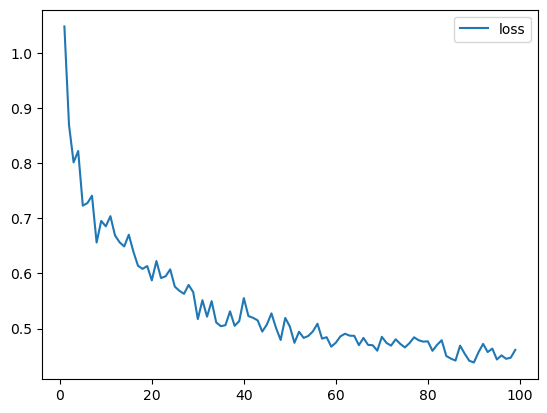

In [22]:
# Create a DataFrame containing training history
history_df = pd.DataFrame(fit_model.history)
print (fit_model.history)

# Increase the index by 1 to match the number of epochs
history_df.index += 1

# Plot the loss
history_df.plot(y="loss")


### Step 4: Save and export your model to a keras file, and name the file `student_loans.keras`.


In [23]:
# Set the model's file path
file_path = Path("student_loans.keras")

# Export your model to a keras file
model.save(file_path)

---
## Predict Loan Repayment Success by Using your Neural Network Model

### Step 1: Reload your saved model.

In [24]:
# Set the model's file path
file_path = Path("student_loans.keras")

# Load the model to a new object
lr_model = load_model(file_path)

### Step 2: Make predictions on the testing data and save the predictions to a DataFrame.

In [25]:
# Make predictions with the test data
predictions = lr_model.predict(X_test_scaled,verbose=2)


# Display a sample of the predictions
display (predictions[:5])

10/10 - 0s - 100ms/epoch - 10ms/step


array([[0.94169897],
       [0.07879221],
       [0.99106795],
       [0.73014337],
       [0.10359788]], dtype=float32)

In [26]:
# Save the predictions to a DataFrame and round the predictions to binary results
predictions_df = pd.DataFrame(data=predictions, columns=['Predicted_Probability'])
# Round predictions to binary results (0 or 1) using 0.5 as the threshold
predictions_df['Predicted_Class'] = round(predictions_df['Predicted_Probability'])
predictions_df.head(20)

,Predicted_Probability,Predicted_Class
0,0.941699,1.0
1,0.078792,0.0
2,0.991068,1.0
3,0.730143,1.0
4,0.103598,0.0
5,0.468621,0.0
6,0.119109,0.0
7,0.352349,0.0
8,0.961202,1.0
9,0.884045,1.0


### Step 4: Display a classification report with the y test data and predictions

In [27]:
# Print the classification report with the y test data and predictions
print(classification_report(y_test, predictions_df["Predicted_Class"].values))

              precision    recall  f1-score   support

           0       0.76      0.76      0.76       157
           1       0.77      0.77      0.77       163

    accuracy                           0.77       320
   macro avg       0.77      0.77      0.77       320
weighted avg       0.77      0.77      0.77       320



---
## Discuss creating a recommendation system for student loans

Briefly answer the following questions in the space provided:

1. Describe the data that you would need to collect to build a recommendation system to recommend student loan options for students. Explain why this data would be relevant and appropriate.

2. Based on the data you chose to use in this recommendation system, would your model be using collaborative filtering, content-based filtering, or context-based filtering? Justify why the data you selected would be suitable for your choice of filtering method.

3. Describe two real-world challenges that you would take into consideration while building a recommendation system for student loans. Explain why these challenges would be of concern for a student loan recommendation system.

1. Describe the data that you would need to collect to build a recommendation system to recommend student loan options for students. Explain why this data would be relevant and appropriate.

Building a recommendation system for student loan options involves collecting and analyzing a variety of data types to ensure personalized and accurate recommendations. Here are some key data categories that would be relevant and why:

1. **Personal Information:**
   - **Age, Gender, Marital Status:** These demographics can affect loan eligibility and terms.
   - **Dependents:** Number of dependents can influence repayment capacity.
   - **Income Level:** Directly impacts ability to repay loans and determines what kind of loan terms are feasible.

2. **Educational Background:**
   - **Type of Institution (public/private, 2-year/4-year):** Different institutions may have different associated costs and potential financial aid options.
   - **Major/Field of Study:** Certain fields might have higher earning potential, affecting loan repayment terms.
   - **Academic Performance (GPA):** Some loan options might offer better terms for higher academic achievements.

3. **Financial History:**
   - **Credit Score:** Essential for assessing risk and determining the interest rates offered.
   - **Current Financial Obligations (e.g., existing loans, rent):** Helps assess debt-to-income ratio.
   - **Employment History:** Stability and type of employment can influence loan repayment conditions.

4. **Loan Requirements:**
   - **Amount Needed:** Essential for matching with suitable loan options.
   - **Preferred Repayment Period:** Influences the types of loans that can be recommended.
   - **Interest Rate Sensitivity:** Some students may prefer lower interest rates with stricter repayment conditions, while others might opt for higher rates with more flexibility.

5. **Geographical Location:**
   - **State/Region:** Loan availability and terms can vary by location due to differing state regulations and cost of living.

6. **Behavioral Data (if using an online system):**
   - **Interaction with Loan Information:** Tracks which loan terms and details catch a student’s attention, which can guide personalized recommendations.
   - **Feedback on Previous Recommendations:** Helps refine future recommendations by learning what was or wasn’t accepted by the user.

Collecting these types of data is critical for building a model that understands the nuanced financial, educational, and personal circumstances of each student. This holistic approach allows the recommendation system to offer the most suitable and sustainable student loan options, tailored to each individual’s unique situation. However, it's also vital to handle this sensitive data with robust privacy measures and comply with all relevant data protection regulations (like GDPR in the EU or CCPA in California) to protect students' privacy and security.







2. Based on the data you chose to use in this recommendation system, would your model be using collaborative filtering, content-based filtering, or context-based filtering? Justify why the data you selected would be suitable for your choice of filtering method.

## Analysis of Data Features

The dataset includes a range of features that can be classified primarily as personal and academic attributes:

### Personal and Financial Attributes:
- `payment_history`
- `financial_aid_score`
- `total_loan_score`

### Academic Attributes:
- `stem_degree_score`
- `gpa_ranking`
- `study_major_code`
- `time_to_completion`

### Workshop and Alumni Metrics:
- `finance_workshop_score`
- `alumni_success`

### Rankings and Scores:
- `cohort_ranking`
- `location_parameter`
- `credit_ranking`

## Choosing a Filtering Method

Given the types of data available, here are the considerations for selecting a suitable filtering method:

### Collaborative Filtering:
This method typically requires user-item interaction data, such as user ratings for items, which doesn't appear to be directly available in your dataset. Collaborative filtering might not be suitable unless there's implicit interaction data that can be derived from the existing features, like inferring preferences from `payment_history` or `credit_ranking`.

### Content-Based Filtering:
This approach seems highly suitable because:
- **You have detailed attributes related to each student's academic and financial background.**
- **Content-based systems can utilize these attributes to recommend loan products or financial options that match closely with individual student profiles based on their needs and past behaviors.**

### Context-Based Filtering:
While you have some features that could be considered contextual, like `location_parameter`, the context does not seem to be the primary driver of the recommendation logic needed for a student loan system. This method might be used to enhance another method but may not be sufficient on its own.

## Justification for Content-Based Filtering

Given the detailed and specific nature of the features in your dataset, content-based filtering is likely the most effective approach for several reasons:

### Personalization:
- It can leverage detailed academic scores, financial scores, and other personal attributes to match students with the most suitable loan options.

### Direct Relevance:
- Features like `finance_workshop_score`, `gpa_ranking`, and `financial_aid_score` provide a solid basis for profiling and matching, as these metrics are likely directly correlated with the suitability of various loan products or financial advice.

### Data Utilization:
- This method can effectively utilize almost all the features you have to create detailed profiles and recommendations, maximizing the use of available data without needing additional information.


3. Describe two real-world challenges that you would take into consideration while building a recommendation system for student loans. Explain why these challenges would be of concern for a student loan recommendation system.

Using machine learning models to set interest rates for student loans can have various real-world implications, both beneficial and challenging. Here are some key considerations:

1. **Fairness and Bias**: One of the primary concerns is the risk of bias in the model. Machine learning models can inadvertently perpetuate or even amplify existing biases if the data on which they are trained is not representative or contains historical biases. This can lead to unfair interest rates for certain groups of students based on factors like race, gender, or socioeconomic background.

2. **Transparency and Explainability**: Machine learning models, especially complex ones like deep learning, can be opaque, meaning it's difficult to understand how they arrive at specific decisions (e.g., interest rates). This lack of transparency can be problematic in finance, where borrowers have the right to understand how their rates are being set.

3. **Regulatory Compliance**: There are numerous regulations in financial services designed to protect consumers, such as the Equal Credit Opportunity Act in the U.S., which prohibits discrimination on the basis of race, color, religion, national origin, sex, marital status, or age. Ensuring that a machine learning model complies with these regulations can be challenging but is crucial.

4. **Accuracy and Reliability**: The accuracy of predictions made by machine learning models depends heavily on the quality and quantity of the data used for training. Inaccuracies in prediction can lead to inappropriate interest rates, which might not accurately reflect the borrower's credit risk.

5. **Economic Impact**: Appropriately set interest rates based on predictive models could potentially make student loans more accessible and affordable to a broader group of students by more accurately assessing risk than traditional models. However, if not carefully managed, it could also lead to increased debt burdens for vulnerable populations.

6. **Ethical Considerations**: There are significant ethical considerations in using AI in scenarios that significantly impact people's lives, like education financing. Ensuring that the use of such technologies is in the best interest of the students rather than purely for profit is crucial.

In deploying machine learning models for setting student loan interest rates, it's important to continuously monitor and update the models to ensure they remain fair, accurate, and compliant with all applicable laws and regulations. Regular audits and transparency with the public can help maintain trust and ensure ethical use of technology in such critical applications.